In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Read CSV

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [3]:
df.shape

(10506, 12)

In [4]:
df.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [6]:
df.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

#### Convert Date Column to datetime Format

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

#### Make New Column for Year, Month, Day

In [8]:
df['Year'] = df['Date'].dt.year

In [9]:
df['Month'] = df['Date'].dt.month

In [10]:
df['Day'] = df['Date'].dt.day

In [11]:
df.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Day
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,2007,5,29


In [16]:
df['Year'].value_counts().sort_values(ascending=False)

2007    3811
2013    2392
2009    2249
2011    2054
Name: Year, dtype: int64

In [17]:
df['Month'].value_counts().sort_values(ascending=False)

8     3751
7     2606
9     2218
6     1571
10     276
5       84
Name: Month, dtype: int64

In [19]:
df['Day'].value_counts().sort_values(ascending=False)[:5]

1     864
12    815
19    674
25    656
15    642
Name: Day, dtype: int64

#### Value Count of Species

In [20]:
df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [21]:
#Can possibly merge bottom two classes.

#### Count of Species Captured

In [22]:
species_count = pd.DataFrame(df.groupby('Species')['NumMosquitos'].sum().sort_values(ascending = False) )
species_count.reset_index(inplace=True)

In [23]:
species_count

,Species,NumMosquitos
0,CULEX PIPIENS/RESTUANS,66268
1,CULEX PIPIENS,44671
2,CULEX RESTUANS,23431
3,CULEX TERRITANS,510
4,CULEX SALINARIUS,145
5,CULEX TARSALIS,7
6,CULEX ERRATICUS,7


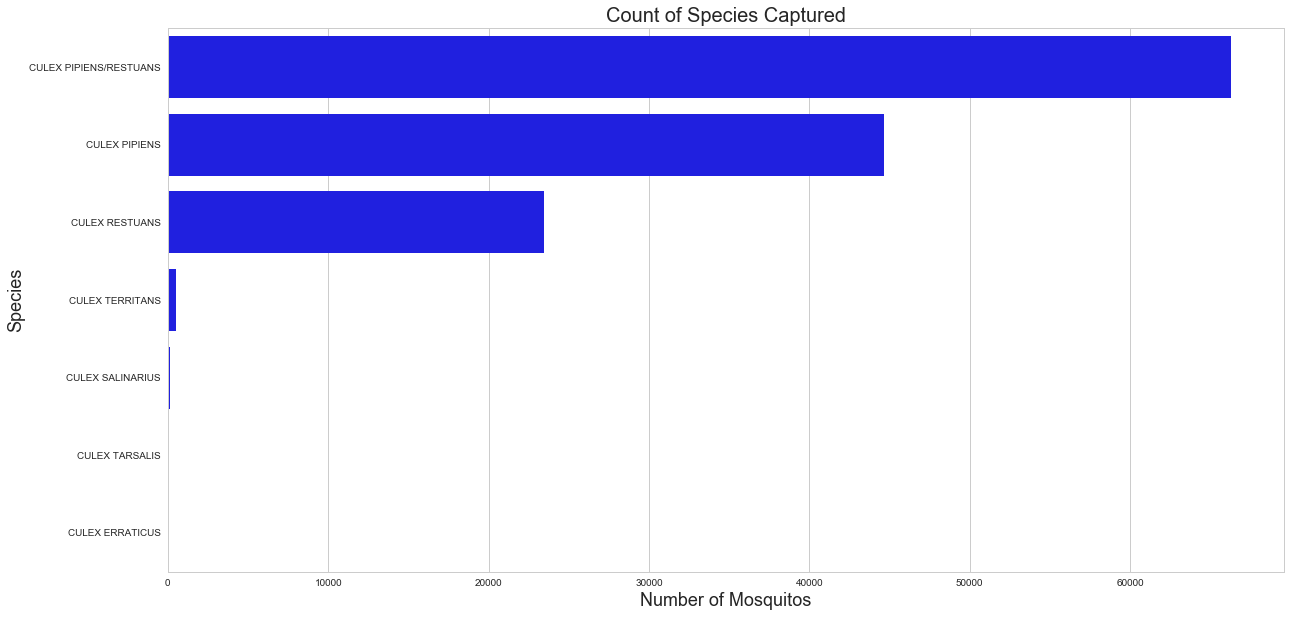

In [101]:
fig, ax = plt.subplots(figsize = (20,10))
ax = sns.barplot(y='Species', x='NumMosquitos', data=species_count, orient = 'h', color='b')
ax.set_xlabel('Number of Mosquitos', fontsize = 18)
ax.set_ylabel('Species', fontsize=18)
ax.set_title('Count of Species Captured', fontsize=20);

plt.savefig('species.png', bbox_inches='tight')

#### Timeline of When Mosquitos Are Caught

In [31]:
df.groupby('Month')['WnvPresent'].sum().sort_values(ascending=False)

Month
8     377
9     125
7      46
10      2
6       1
5       0
Name: WnvPresent, dtype: int64

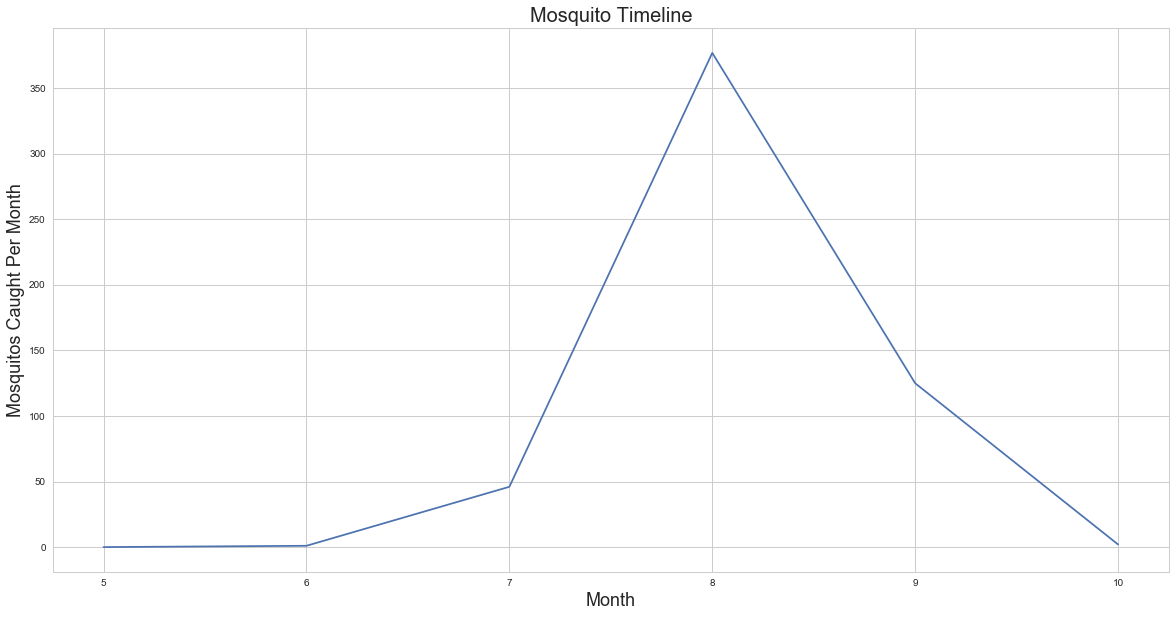

In [103]:
fig, ax = plt.subplots(figsize = (20,10))

plt.plot(df.groupby('Month')['WnvPresent'].sum())
ax.set_title('Mosquito Timeline', fontsize=20)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Mosquitos Caught Per Month', fontsize=18);

plt.savefig('mosquito_timeline1', bbox_inches='tight')

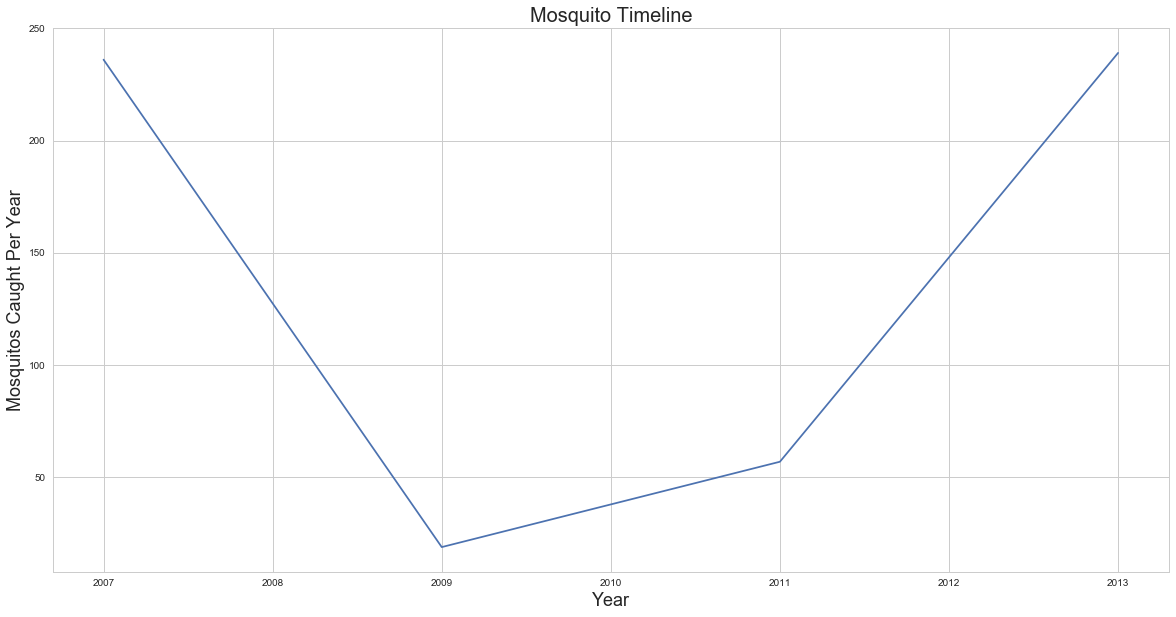

In [104]:
fig, ax = plt.subplots(figsize = (20,10))

plt.plot(df.groupby('Year')['WnvPresent'].sum())
ax.set_title('Mosquito Timeline', fontsize=20)
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Mosquitos Caught Per Year', fontsize=18);

plt.savefig('mosquito_timeline2', bbox_inches='tight')

#### Mosquitos Caught Per Block

In [99]:
block_df = pd.DataFrame(data = df.groupby('Block')['WnvPresent'].sum(), columns=['WnvPresent'])
block_df.reset_index(inplace=True)

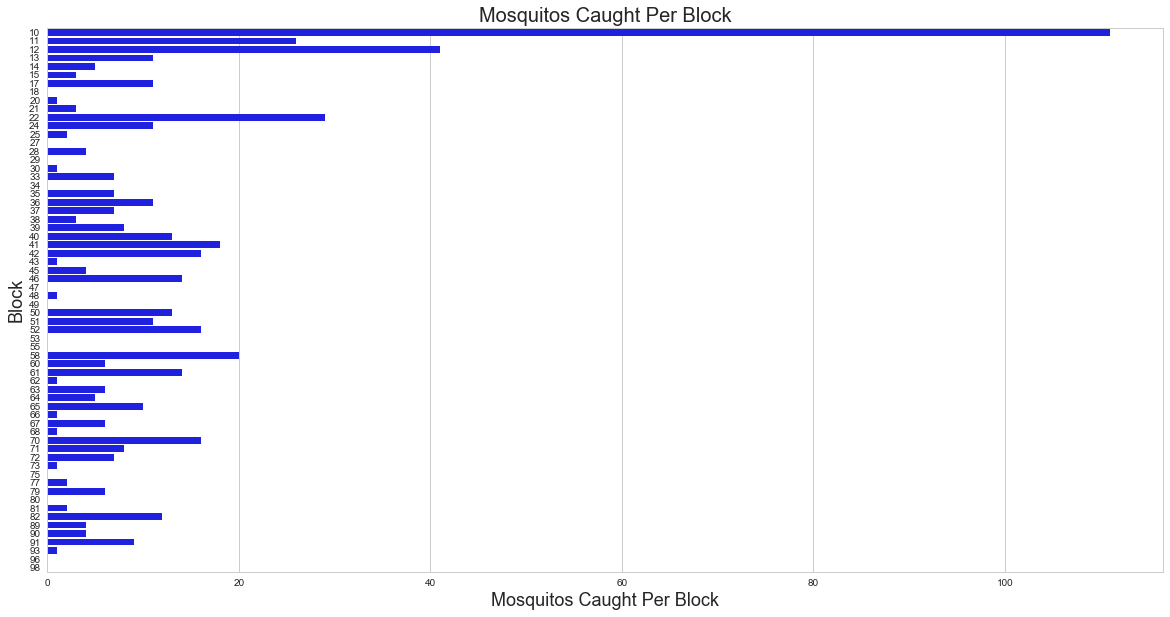

In [105]:
fig, ax = plt.subplots(figsize = (20,10))

sns.barplot(y = block_df['Block'], x = block_df['WnvPresent'], orient='h', color='blue')
ax.set_title('Mosquitos Caught Per Block', fontsize=20)
ax.set_xlabel('Mosquitos Caught Per Block', fontsize=18)
ax.set_ylabel('Block', fontsize=18);

plt.savefig('mosquito_block', bbox_inches='tight')

#### WnvPresent Class Distribution

In [73]:
df['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64